# Summary

----

# Imports

In [1]:
%run imports.ipynb

2016-09-07 03:51:35.232903


In [10]:
%run db.ipynb

MySQL database already running...


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-09-07 03:52:20.239807


In [11]:
NOTEBOOK_NAME = 'core_machine_learning'
os.environ['NOTEBOOK_NAME'] = NOTEBOOK_NAME

# Load data

In [96]:
DATA_DF = pd.read_pickle(op.join('load_data', 'DATA_DF_TT_CORE.pkl'))

In [97]:
DIFFSEQI = True

if DIFFSEQI:
    protherm_dataset_name = 'protherm++'
    taipale_dataset_name = 'taipale_diffseqi'
else:
    protherm_dataset_name = 'protherm'
    taipale_dataset_name = 'taipale'

## Leave class out group

## Add Pfam clan info

In [98]:
sql_query = """\
SELECT *
from pfam.pfam_a_regions
where uniprot_id in ({})
""".format(", ".join(DATA_DF['uniprot_id'].drop_duplicates().apply(lambda x: "'{}'".format(x))))

pfam_a_regions = pd.read_sql_query(sql_query, db_remote.engine)

In [99]:
def get_pfam_id(uniprot_id, mutation):
    if pd.isnull(uniprot_id) or pd.isnull(mutation):
        return np.nan
    mutation_pos = int(mutation[1:-1])
    df = (
        pfam_a_regions[
            (pfam_a_regions['uniprot_id'] == uniprot_id) &
            (pfam_a_regions['domain_start'] <= mutation_pos) &
            (pfam_a_regions['domain_end'] >= mutation_pos)
        ]['pfam_id']
    )
    if len(df):
        pfam_id = df.values[0]
    else:
        pfam_id = np.nan
    return pfam_id


assert get_pfam_id('P01820', 'A20C') == 'PF07686'
assert get_pfam_id('P01820', 'A10C') is np.nan
assert get_pfam_id('P00974', 'A39X') == 'PF00014'
assert get_pfam_id('P00974', 'A91X') == 'PF00014'
assert get_pfam_id('P00974', 'A92X') is np.nan

AssertionError: 

In [ ]:
DATA_DF.loc[
    DATA_DF['pfam_id'].isnull() & DATA_DF['uniprot_id'].notnull() & DATA_DF['mutation'].notnull(), 
    'pfam_id'
] = (
    DATA_DF.loc[
        DATA_DF['pfam_id'].isnull() & DATA_DF['uniprot_id'].notnull() & DATA_DF['mutation'].notnull(), 
        ['uniprot_id', 'mutation']
    ].apply(lambda x: get_pfam_id(*x), axis=1)
)

In [ ]:
sql_query = """\
SELECT *
from pfam.pfam_a_clans
"""
pfam_a_clans = pd.read_sql_query(sql_query, db_remote.engine).set_index('pfam_id')['clan_id']

In [ ]:
DATA_DF.loc[
    DATA_DF['pfam_clan'].isnull() & DATA_DF['pfam_id'].notnull(), 
    'pfam_clan'
] = (
    DATA_DF.loc[
        DATA_DF['pfam_clan'].isnull() & DATA_DF['pfam_id'].notnull(),
        'pfam_id'
    ].map(pfam_a_clans)
)

In [ ]:
uniprot_id_to_pfam_clan = {
    k: v
    for k, v
    in DATA_DF[['uniprot_id', 'pfam_clan']].dropna().values
}

In [ ]:
pdb_id_to_pfam_clan = {
    k: v
    for k, v
    in DATA_DF[['pdb_id', 'pfam_clan']].dropna().values
}

In [ ]:
def get_lco_id(pfam_clan, uniprot_id, pdb_id):
    
    pfam_clan_from_uniprot = uniprot_id_to_pfam_clan.get(uniprot_id)
    pfam_clan_from_pdb = pdb_id_to_pfam_clan.get(pdb_id)

    if pd.notnull(pfam_clan):
        return pfam_clan    
    elif pd.notnull(pfam_clan_from_uniprot):
        return pfam_clan_from_uniprot
    elif pd.notnull(pfam_clan_from_pdb):
        return pfam_clan_from_pdb
    elif pd.notnull(uniprot_id):
        return uniprot_id
    elif pd.notnull(pdb_id):
        return pdb_id

In [ ]:
DATA_DF['lco_id'] = [
    get_lco_id(*x)
    for x in DATA_DF[['pfam_clan', 'uniprot_id', 'pdb_id']].values
]

In [ ]:
def get_class_sets(n_classes=6, **args):
    """
    args : Counter
        key : num rows assigned to that key
    """
    args = sorted(args.items(), key=lambda x: x[1], reverse=True)
    num_rows = sum(v[1] for v in args)
    rows_per_class = num_rows // n_classes + 1

    class_sets = []
    for i in range(n_classes):
        class_set = {args.pop(0)}
        while sum(v[1] for v in class_set) < rows_per_class:
            try:
                class_set.add(args.pop(-1))
            except IndexError:
                break
        class_sets.append(class_set)
    assert not args
    return class_sets

In [ ]:
DATA_DF['dataset'].drop_duplicates()

In [94]:
DATA_DF[DATA_DF['dataset'] == 'protherm++']

,_index,alignment_coverage,alignment_filename_1,alignment_filename_2,alignment_identity,alignment_score,backbone_clash_change,backbone_clash_wt,backbone_hbond_change,backbone_hbond_wt,cath_id_1,cath_id_2,chain_1,chain_2,chain_modeller,cis_bond_change,cis_bond_wt,conserved_1,conserved_2,conserved_if_1,conserved_if_2,contact_distance_change,contact_distance_wt,coverage_1,coverage_2,coverage_if_1,coverage_if_2,dataset,db,ddg,ddg_exp,del_class_exp,del_score_exp,dg_change,dg_wt,disulfide_change,disulfide_wt,domain_contact_id,domain_contact_ids,electrostatic_kon_change,electrostatic_kon_wt,electrostatics_change,electrostatics_wt,energy_ionisation_change,energy_ionisation_wt,entropy_complex_change,entropy_complex_wt,entropy_mainchain_change,entropy_mainchain_wt,entropy_sidechain_change,entropy_sidechain_wt,gene_name,helix_dipole_change,helix_dipole_wt,id,identical_1,identical_2,identical_if_1,identical_if_2,idx,idxs,interacting_aa_1,interacting_aa_2,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,interface_dg,intraclashes_energy_1_change,intraclashes_energy_1_wt,intraclashes_energy_2_change,intraclashes_energy_2_wt,m_date_modified,matrix_score,max_seq_identity,mloop_entropy_change,mloop_entropy_wt,model_domain_def_1,model_domain_def_2,model_errors,model_file_mut,model_file_wt,model_filename,model_filename_mut,model_filename_wt,mut_date_modified,mutation,mutation_errors,mutation_modeller,norm_dope,number_of_residues,organism_name,partial_covalent_bonds_change,partial_covalent_bonds_wt,partner_pdb_chain,partner_uniprot_id,path_to_data,pcv_hbond_change,pcv_hbond_self_change,pcv_hbond_self_wt,pcv_hbond_wt,pcv_salt_equal_change,pcv_salt_equal_self_change,pcv_salt_equal_self_wt,pcv_salt_equal_wt,pcv_salt_opposite_change,pcv_salt_opposite_self_change,pcv_salt_opposite_self_wt,pcv_salt_opposite_wt,pcv_vdw_change,pcv_vdw_self_change,pcv_vdw_self_wt,pcv_vdw_wt,pdb_chain,pdb_id,pdb_mutation,pfam_clan,pfam_id,protein_existence,protein_name,provean_score,rigids,score_1,score_2,score_if_1,score_if_2,score_if_total,score_overall,score_total,secondary_structure_change,secondary_structure_wt,sequence_version,sidechain_hbond_change,sidechain_hbond_wt,sloop_entropy_change,sloop_entropy_wt,solvation_hydrophobic_change,solvation_hydrophobic_wt,solvation_polar_change,solvation_polar_wt,solvent_accessibility_change,solvent_accessibility_wt,stability_energy_mut,stability_energy_wt,t_date_modified,template_errors,torsional_clash_change,torsional_clash_wt,uniprot_domain_id_1,uniprot_domain_id_2,uniprot_domain_pair_id,uniprot_domain_pair_id_old,uniprot_id,uniprot_id_1,uniprot_id_2,uniprot_mutation,uniprot_name,uniprot_sequence,van_der_waals_change,van_der_waals_clashes_change,van_der_waals_clashes_wt,van_der_waals_wt,water_bridge_change,water_bridge_wt,lco_id


In [83]:
c = Counter(DATA_DF[DATA_DF['dataset'] == 'protherm++']['lco_id'])
class_sets = get_class_sets(**c, n_classes=5)

IndexError: pop from empty list

In [91]:
Counter(DATA_DF['lco_id'])

Counter({'O15211': 20,
         'Q9ULW0': 7,
         'Q3SY84': 81,
         'P43489': 3,
         'Q9UNL4': 4,
         'P46783': 3,
         'O75306': 15,
         'P47872': 4,
         'Q9Y2X3': 11,
         'P14780': 14,
         'P51784': 2,
         'P46776': 1,
         'O14867': 3,
         'P15923': 86,
         'P30532': 7,
         'O00175': 2,
         'P31151': 2,
         'Q9H8M2': 3,
         'CL0230': 10,
         'P10073': 17,
         'O60610': 7,
         'CL0221': 1154,
         'Q9Y294': 14,
         'O15061': 2,
         'P56704': 11,
         'Q9BRX5': 1,
         'CL0018': 236,
         'Q15697': 6,
         'P14136': 33,
         'P38507': 15,
         'CL0433': 1,
         'Q9BXR6': 1,
         'P43004': 9,
         'Q9BTC8': 1,
         'O94827': 11,
         'P01009': 59,
         'CL0107': 6,
         'Q96HS1': 1,
         'P45378': 3,
         'O60885': 21,
         'Q16515': 5,
         'Q01534': 1,
         'Q9BPZ3': 3,
         'P06730': 7,
         'P4

In [11]:
DATA_DF['lco_group'] = None

for i, class_set in enumerate(class_sets):
    cs = {k[0] for k in class_set}
    print('{:d}:\t{}'.format(i, cs))
    DATA_DF.loc[
        (DATA_DF['dataset'] == protherm_dataset_name) &
        (DATA_DF['pfam_clan'].isin(cs)),
        'lco_group'] = i
    
assert not DATA_DF[DATA_DF['dataset'] == protherm_dataset_name]['lco_group'].isnull().any()

0:	{'Rubredoxin', 'TIM', 'PTE', 'Beta-lactamase', 'Kringle', 'RRM_1', 'HTH_3', 'Ank', 'cNMP_binding', 'Pec_lyase-like', 'KIX', 'Sod_Fe_N+Sod_Fe_C', 'Endostatin', 'Lipase_2', 'Colicin_Pyocin', 'Rop', 'potato_inhibit', 'DSBA', 'HMG_box', 'S_100', 'NTF2', 'Periplas_BP', 'Inh', 'EF-hand_7', '4H_Cytokine', 'Viral_Gag', 'IHF-likeDNA-bdg', 'HTH', 'DIM1', 'A_deaminase', 'Plug+TonB_dep_Rec', 'I-set', 'Sialidase', 'ELFV_dehydrog_N+ELFV_dehydrog', 'Barstar', 'Cpn10', 'ATP-gua_PtransN+ATP-gua_Ptrans', 'Apolipoprotein', 'Phage_lysozyme', 'Glyco_hydro_tim', 'Thioredoxin_4', 'tRNA-synt_1b', 'WW', 'Myb_DNA-bind_6+Myb_DNA-binding', 'OmpA_membrane', 'PagP', 'CUE', 'Endotoxin_N', 'Peptidase_S8', 'Ribosomal_L9_C', 'Tissue_fac+Interfer-bind', 'Pkinase_Tyr', 'VHP'}
1:	{'bZIP_1', 'SSI', 'SBP_bac_1', 'PGK', 'Cytochrome_CBB3', 'Response_reg', 'Hormone_1', '7kD_DNA_binding', 'PTS-HPr', 'Crystall', 'ADK', 'Phospholip_A2_1', 'Cyt-b5', 'Insulin', 'Carb_anhydrase', 'C1-set', 'Ribonuclease', 'Ribosomal_S6', 'Prion',

## TRAINING_SETS_NONULL

In [12]:
# Remove rows with missing features
TRAINING_SETS_NONULL = OrderedDict()
for dataset in sorted(DATA_DF['dataset'].drop_duplicates()):
    df = DATA_DF[DATA_DF['dataset'] == dataset].copy()
    _shape_before = df.shape[0]
    df = df.dropna(subset=elaspic.elaspic_predictor.FEATURE_COLUMNS_CORE, how='any')
    df = df.dropna(subset=['ddg_exp', 'del_score_exp', 'del_class_exp'], how='all')
    _shape_after = df.shape[0]
    TRAINING_SETS_NONULL[dataset] = df

    print(dataset)
    print("Shape before:\t{:,d}".format(_shape_before))
    print("Shape after:\t{:,d}".format(_shape_after))
    print("Rows lost:\t{:,d}".format(_shape_before - _shape_after))
    print('-' * 40)

clinvar
Shape before:	63,331
Shape after:	58,236
Rows lost:	5,095
----------------------------------------
clinvar_test
Shape before:	19,072
Shape after:	17,741
Rows lost:	1,331
----------------------------------------
clinvar_train
Shape before:	44,259
Shape after:	40,495
Rows lost:	3,764
----------------------------------------
cosmic
Shape before:	347,271
Shape after:	328,506
Rows lost:	18,765
----------------------------------------
cosmic_test
Shape before:	101,418
Shape after:	96,865
Rows lost:	4,553
----------------------------------------
cosmic_train
Shape before:	245,853
Shape after:	231,641
Rows lost:	14,212
----------------------------------------
humsavar
Shape before:	29,456
Shape after:	28,786
Rows lost:	670
----------------------------------------
humsavar_test
Shape before:	8,116
Shape after:	7,964
Rows lost:	152
----------------------------------------
humsavar_train
Shape before:	21,340
Shape after:	20,822
Rows lost:	518
----------------------------------------
proth

# Cross-validation

## system_commands

In [13]:
data_file = op.join(NOTEBOOK_NAME, 'TRAINING_SETS_NONULL.pkl')
with open(data_file, 'wb') as ofh:
    pickle.dump(TRAINING_SETS_NONULL, ofh, pickle.HIGHEST_PROTOCOL)

In [14]:
# Generate a list of parameters that we want to try...
FEATURE_COLUMNS = elaspic.elaspic_predictor.FEATURE_COLUMNS_CORE[:]
FEATURE_COLUMNS.remove('dg_change')

parameter_grid =  {
    'data_set': [protherm_dataset_name],
    'data_file': [op.abspath(op.join(NOTEBOOK_NAME, 'TRAINING_SETS_NONULL.pkl'))],
    'n_estimators': [2000],
    'loss': ['huber'],
    'learning_rate': [0.1, 0.05, 0.02, 0.01],
    'max_depth': [4, 6,   8, 10],
    'min_samples_leaf': [3, 5, 9, 13, 17,   21, 29],
    'max_features': [1.0, 0.3, 0.1,   0.8, 0.5],
    'alpha': [0.99, 0.95, 0.9, 0.8, 0.7, 0.5],
    'features': [':'.join(FEATURE_COLUMNS)],
}


def get_system_command(**params):
    system_command = (
        "{python} {script} {args}".format(
            python=sys.executable,
            script=op.abspath(op.join(NOTEBOOK_NAME, '_reg_gridsearch.py')),
            args=' '.join(sorted("--{} {}".format(*x) for x in params.items())))
    )
    return system_command


system_commands = [
    (i, get_system_command(**params)) 
    for i, params 
    in enumerate(jobsubmitter.iterate_parameters(**parameter_grid))
]

print("Size of the parameter grid: ", len(system_commands))

Size of the parameter grid:  3360


## _reg_gridsearch.py

In [15]:
%%file $NOTEBOOK_NAME/_reg_gridsearch.py
import os
import os.path as op
import pickle
import json
import scipy as sp
import pandas as pd
import sqlalchemy as sa
from sklearn import ensemble, cross_validation, metrics
import elaspic


def cross_validate(train_df, valid_dfs, opts, features, do_xval, target='ddg_exp', label='lco_group'):
    # Initialize classifier
    clf = ensemble.GradientBoostingRegressor(**opts)
    
    # Keep track of results
    result = {}
    def add_stats(actual, predicted, suffix=''):
        result.update({
                'r2{}'.format(suffix): metrics.r2_score(actual, predicted),
                'pearsonr{}'.format(suffix): sp.stats.pearsonr(actual, predicted)[0],
                'spearmanr{}'.format(suffix): sp.stats.spearmanr(actual, predicted)[0],
            })

    # Cross-validation        
    if do_xval:
        preds = cross_validation.cross_val_predict(
            estimator=clf,
            X=train_df[features],
            y=train_df[target],
            cv=cross_validation.LeaveOneLabelOut(train_df[label].fillna('')),
            n_jobs=1,
        )
        add_stats(train_df[target], preds)

    # Fit the classifier
    clf.fit(train_df[features], train_df[target])

    # Validation on our 'test' sets
    for valid_name, valid_df in valid_dfs.items():
        valid_df['pred'] = clf.predict(valid_df[features])
        for col_name, do_abs in [
                ('ddg_exp', False),
                ('del_score_exp', True),
                ('del_class_exp', True)]:
            if not valid_df[col_name].notnull().all():
                continue
            actual = valid_df[col_name].abs() if do_abs else valid_df[col_name]
            predicted = valid_df['pred'].abs() if do_abs else valid_df['pred']
            suffix = '_{}_{}_vs_ddg{}'.format(valid_name, col_name, '_abs' if do_abs else '')
            add_stats(actual, predicted, suffix)
            for cutoff_name, cutoff_func in [
                    ('gt80', lambda x: x > 80),
                    ('40to80', lambda x: (x <= 80) & (x > 40)),
                    ('lt40', lambda x: x <= 40)]:
                keep_idx = valid_df['alignment_identity'].apply(cutoff_func)
                add_stats(actual[keep_idx], predicted[keep_idx], suffix + '_' + cutoff_name)

    # DONE!
    return result


if __name__ == '__main__':
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_set', type=str, required=True)
    parser.add_argument('--data_file', type=str, required=True)
    parser.add_argument('--features', type=str, default=None)
    parser.add_argument('--do_xval', type=int, default=1)
    # 
    parser.add_argument('--learning_rate', type=float, required=True)
    parser.add_argument('--max_depth', type=int, required=True)
    parser.add_argument('--min_samples_leaf', type=int, required=True)
    parser.add_argument('--max_features', type=float, required=True)
    parser.add_argument('--alpha', type=float, required=True)
    #
    parser.add_argument('--loss', type=str, default='huber')
    parser.add_argument('--n_estimators', type=int, default=3000)
    #
    args = parser.parse_args()

    with open(args.data_file, 'rb') as ifh:
        TRAINING_SETS = pickle.load(ifh)
    
    train_df = TRAINING_SETS[args.data_set]
    validation_dfs = {
        # Training / validation datasets
        **{
            key.replace('_train', ''): df_valid 
            for (key, df_valid) in TRAINING_SETS.items()
            if key.endswith('_train')
        },
        # Test datasets
        **{
            key: df_valid 
            for (key, df_valid) in TRAINING_SETS.items()
            if key.endswith('_test')
        },
    }
    clf_opts = {
        k: v for (k, v) in args.__dict__.items()
        if k not in ['data_set', 'data_file', 'features', 'do_xval']
    }
    features = args.features.split(':')
        
    clf_result = cross_validate(train_df, validation_dfs, clf_opts, features, do_xval=bool(args.do_xval))

    result = {'clf_opts': clf_opts, 'features': args.features, **clf_result}
    print(json.dumps(result))

Overwriting core_machine_learning/_reg_gridsearch.py


In [16]:
!python $NOTEBOOK_NAME/_reg_gridsearch.py \
    --data_set $protherm_dataset_name --data_file $data_file --features {':'.join(FEATURE_COLUMNS)} --do_xval 0 \
    --learning_rate 0.1 --max_depth 4 --min_samples_leaf 3 --max_features 1.0 --alpha=0.95 --n_estimators 100

{"spearmanr_cosmic_del_class_exp_vs_ddg_abs_40to80": 0.08166606990862313, "spearmanr_cosmic_del_class_exp_vs_ddg_abs_lt40": 0.03166119594619487, "pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_40to80": 0.0662961882329313, "pearsonr_taipale_diffseqi_ddg_exp_vs_ddg_40to80": 0.0047412717279864194, "r2_taipale_ddg_exp_vs_ddg_lt40": -1.0231790823665747, "pearsonr_cosmic_del_score_exp_vs_ddg_abs_40to80": 0.097785422636717, "pearsonr_humsavar_del_class_exp_vs_ddg_abs_lt40": 0.03807780946831253, "pearsonr_cosmic_del_class_exp_vs_ddg_abs_lt40": 0.03439055122422029, "pearsonr_clinvar_del_class_exp_vs_ddg_abs": 0.09109071330452155, "r2_taipale_diffseqi_test_ddg_exp_vs_ddg_gt80": -0.6385778245079563, "spearmanr_taipale_diffseqi_ddg_exp_vs_ddg_lt40": 0.12599437221518245, "r2_taipale_ddg_exp_vs_ddg": -0.7270270404256987, "spearmanr_cosmic_del_score_exp_vs_ddg_abs_lt40": 0.037567374289967356, "r2_clinvar_test_del_class_exp_vs_ddg_abs_lt40": -5.052479751826919, "pearsonr_clinvar_test_del_class_exp_vs_

## Cross-validate

**Cross-validation...**

The cross-validation score here is correct, but the validation scores used a wrong metric and have to be re-done...

### QSUB

In [17]:
# Run gridsearch on cluster
log_base_dir = op.abspath(op.join(NOTEBOOK_NAME, '_reg_gridsearch'))

js = jobsubmitter.JobSubmitter(
    'xv_all_features{}'.format('_diffseqi' if DIFFSEQI else ''),
    # 'xv_wout_dg_change{}'.format('_diffseqi' if DIFFSEQI else ''),
    'sge://:@192.168.6.201', log_base_dir,
    email='ostrokach@gmail.com', force_new_folder=False,
    nproc=1, queue='medium', walltime='06:00:00', mem='6G',
)

Using an existing folder for log output. This is dangerous!!!


### Resubmit failed

In [18]:
# Get job status
results_df = js.job_status(system_commands)
print(Counter(results_df['status']))

Counter({'done': 3360})


In [19]:
# Job statistics
failed = set(results_df[results_df['status'] != 'done']['job_id'])
system_commands_remaining = [x for x in system_commands if x[0] in failed]
print(len(system_commands_remaining))

0


In [20]:
assert not system_commands_remaining

## Validate on external data

In [21]:
parameter_grid_noxval = parameter_grid.copy()
parameter_grid_noxval['do_xval'] = [0]
system_commands_noxval = [
    (i, get_system_command(**params))
    for i, params
    in enumerate(jobsubmitter.iterate_parameters(**parameter_grid_noxval))
]

In [22]:
print(len(system_commands_noxval))

3360


### QSUB

In [23]:
# Beagle
log_base_dir = op.abspath(op.join(NOTEBOOK_NAME, '_reg_gridsearch'))

js_noxval = jobsubmitter.JobSubmitter(
    'xv_wout_dg_change{}_seqisubsets_corrected'.format('_diffseqi' if DIFFSEQI else ''),
    'sge://:@192.168.6.201', log_base_dir,
    email='ostrokach@gmail.com', force_new_folder=False,
    nproc=1, queue='medium', walltime='06:00:00', mem='6G',
)

Using an existing folder for log output. This is dangerous!!!


In [24]:
print(js_noxval.job_name)

xv_wout_dg_change_diffseqi_seqisubsets_corrected


### Resubmit failed


In [25]:
# Get job status
results_df_noxval = js_noxval.job_status(system_commands)
print(Counter(results_df_noxval['status']))

Counter({'done': 3360})


In [26]:
results_df_noxval[results_df_noxval['status'] == 'done'].head(2)

,clf_opts,job_id,pearsonr_clinvar_del_class_exp_vs_ddg_abs,pearsonr_clinvar_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_class_exp_vs_ddg_abs,pearsonr_cosmic_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_score_exp_vs_ddg_abs,pearsonr_cosmic_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_lt40,pearsonr_humsavar_del_class_exp_vs_ddg_abs,pearsonr_humsavar_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_lt40,pearsonr_protherm_ddg_exp_vs_ddg,pearsonr_protherm_ddg_exp_vs_ddg_40to80,pearsonr_protherm_ddg_exp_vs_ddg_gt80,pearsonr_protherm_ddg_exp_vs_ddg_lt40,pearsonr_taipale_ddg_exp_vs_ddg,pearsonr_taipale_ddg_exp_vs_ddg_40to80,pearsonr_taipale_ddg_exp_vs_ddg_gt80,pearsonr_taipale_ddg_exp_vs_ddg_lt40,pearsonr_taipale_diffseqi_ddg_exp_vs_ddg,pearsonr_taipale_diffseqi_ddg_exp_vs_ddg_40to80,pearsonr_taipale_diffseqi_ddg_exp_vs_ddg_gt80,pearsonr_taipale_diffseqi_ddg_exp_vs_ddg_lt40,r2_clinvar_del_class_exp_vs_ddg_abs,r2_clinvar_del_class_exp_vs_ddg_abs_40to80,r2_clinvar_del_class_exp_vs_ddg_abs_gt80,r2_clinvar_del_class_exp_vs_ddg_abs_lt40,r2_cosmic_del_class_exp_vs_ddg_abs,r2_cosmic_del_class_exp_vs_ddg_abs_40to80,r2_cosmic_del_class_exp_vs_ddg_abs_gt80,r2_cosmic_del_class_exp_vs_ddg_abs_lt40,r2_cosmic_del_score_exp_vs_ddg_abs,r2_cosmic_del_score_exp_vs_ddg_abs_40to80,r2_cosmic_del_score_exp_vs_ddg_abs_gt80,r2_cosmic_del_score_exp_vs_ddg_abs_lt40,r2_humsavar_del_class_exp_vs_ddg_abs,r2_humsavar_del_class_exp_vs_ddg_abs_40to80,r2_humsavar_del_class_exp_vs_ddg_abs_gt80,r2_humsavar_del_class_exp_vs_ddg_abs_lt40,r2_protherm_ddg_exp_vs_ddg,r2_protherm_ddg_exp_vs_ddg_40to80,r2_protherm_ddg_exp_vs_ddg_gt80,r2_protherm_ddg_exp_vs_ddg_lt40,r2_taipale_ddg_exp_vs_ddg,r2_taipale_ddg_exp_vs_ddg_40to80,r2_taipale_ddg_exp_vs_ddg_gt80,r2_taipale_ddg_exp_vs_ddg_lt40,r2_taipale_diffseqi_ddg_exp_vs_ddg,r2_taipale_diffseqi_ddg_exp_vs_ddg_40to80,r2_taipale_diffseqi_ddg_exp_vs_ddg_gt80,r2_taipale_diffseqi_ddg_exp_vs_ddg_lt40,spearmanr_clinvar_del_class_exp_vs_ddg_abs,spearmanr_clinvar_del_class_exp_vs_ddg_abs_40to80,spearmanr_clinvar_del_class_exp_vs_ddg_abs_gt80,spearmanr_clinvar_del_class_exp_vs_ddg_abs_lt40,spearmanr_cosmic_del_class_exp_vs_ddg_abs,spearmanr_cosmic_del_class_exp_vs_ddg_abs_40to80,spearmanr_cosmic_del_class_exp_vs_ddg_abs_gt80,spearmanr_cosmic_del_class_exp_vs_ddg_abs_lt40,spearmanr_cosmic_del_score_exp_vs_ddg_abs,spearmanr_cosmic_del_score_exp_vs_ddg_abs_40to80,spearmanr_cosmic_del_score_exp_vs_ddg_abs_gt80,spearmanr_cosmic_del_score_exp_vs_ddg_abs_lt40,spearmanr_humsavar_del_class_exp_vs_ddg_abs,spearmanr_humsavar_del_class_exp_vs_ddg_abs_40to80,spearmanr_humsavar_del_class_exp_vs_ddg_abs_gt80,spearmanr_humsavar_del_class_exp_vs_ddg_abs_lt40,spearmanr_protherm_ddg_exp_vs_ddg,spearmanr_protherm_ddg_exp_vs_ddg_40to80,spearmanr_protherm_ddg_exp_vs_ddg_gt80,spearmanr_protherm_ddg_exp_vs_ddg_lt40,spearmanr_taipale_ddg_exp_vs_ddg,spearmanr_taipale_ddg_exp_vs_ddg_40to80,spearmanr_taipale_ddg_exp_vs_ddg_gt80,spearmanr_taipale_ddg_exp_vs_ddg_lt40,spearmanr_taipale_diffseqi_ddg_exp_vs_ddg,spearmanr_taipale_diffseqi_ddg_exp_vs_ddg_40to80,spearmanr_taipale_diffseqi_ddg_exp_vs_ddg_gt80,spearmanr_taipale_diffseqi_ddg_exp_vs_ddg_lt40,status,~system_command
0,"{'alpha': 0.99, 'max_depth': 4, 'max_features'...",0,0.091553,0.079699,0.148044,0.025360,0.063844,0.074360,0.070497,0.057695,0.073212,0.083080,0.081485,0.067282,0.173246,0.147160,0.230215,0.082258,0.791327,0.942058,0.790376,NaN,0.078330,-0.116656,0.110645,0.090409,0.071628,0.031239,0.124573,0.078332,-6.904569,-8.874326,-5.976679,-8.750627,-7.561134,-6.829046,-8.684376,-7.835672,-11.170784,-9.657926,-12.962843,-12.056766,-7.084015,-7.625421,-6.852940,-7.658469,

In [27]:
# Job statistics
failed = set(results_df_noxval[results_df_noxval['status'] != 'done']['job_id'])
system_commands_remaining = [x for x in system_commands if x[0] in failed]
print(len(system_commands_remaining))

0


In [28]:
assert not system_commands_remaining

## Results

Either from [Cross-validate](#Cross-validate) or [Validate on external data](#Validate-on-external-data), depending on which was sourced last.

In [29]:
if True:
    results_df_all = results_df.copy()
else:
    results_df_all = results_df_noxval.merge(results_df, on=['job_id'], suffixes=('', '_old'))
    results_df_all = results_df_all[[c for c in results_df_all.columns if not c.endswith('_old')]]
print(results_df.shape)
print(results_df_all.shape)

(3360, 79)
(3360, 79)


### Correlation

In [30]:
CORRELATION_TYPE = 'spearmanr'
SUFFIX = ''

In [31]:
# Compute FoldX correlations
foldx_corrs = {}

foldx_corrs.update({
    CORRELATION_TYPE: sp.stats.spearmanr(
        TRAINING_SETS_NONULL[protherm_dataset_name]['dg_change'].values,
        TRAINING_SETS_NONULL[protherm_dataset_name]['ddg_exp'].values
    )[0],
    '{}_{}_ddg_exp_vs_ddg'.format(CORRELATION_TYPE, taipale_dataset_name): sp.stats.spearmanr(
        TRAINING_SETS_NONULL[taipale_dataset_name]['dg_change'].values,
        TRAINING_SETS_NONULL[taipale_dataset_name]['ddg_exp'].values
    )[0],
    '{}_humsavar_del_class_exp_vs_ddg_abs'.format(CORRELATION_TYPE): sp.stats.spearmanr(
        TRAINING_SETS_NONULL['humsavar']['dg_change'].abs().values,
        TRAINING_SETS_NONULL['humsavar']['del_class_exp'].values
    )[0],
    '{}_clinvar_del_class_exp_vs_ddg_abs'.format(CORRELATION_TYPE): sp.stats.spearmanr(
        TRAINING_SETS_NONULL['clinvar']['dg_change'].abs().values,
        TRAINING_SETS_NONULL['clinvar']['del_class_exp'].values
    )[0],
    '{}_cosmic_del_class_exp_vs_ddg_abs'.format(CORRELATION_TYPE): sp.stats.spearmanr(
        TRAINING_SETS_NONULL['cosmic']['dg_change'].abs().values,
        TRAINING_SETS_NONULL['cosmic']['del_class_exp'].values
    )[0]
})

In [32]:
# Compute FoldX correlations at different sequence identity cutoffs
for cutoff_name, cutoff_func in [
        ('_gt80', lambda x: x > 80),
        ('_40to80', lambda x: (x <= 80) & (x > 40)),
        ('_lt40', lambda x: x <= 40)]:
    keep_idx = TRAINING_SETS_NONULL[taipale_dataset_name]['alignment_identity'].apply(cutoff_func)
    foldx_corrs.update({
        '{}_{}_ddg_exp_vs_ddg{}'.format(CORRELATION_TYPE, taipale_dataset_name, cutoff_name): sp.stats.spearmanr(
            TRAINING_SETS_NONULL[taipale_dataset_name][
                     TRAINING_SETS_NONULL[taipale_dataset_name]['alignment_identity'].apply(cutoff_func)
                ]['dg_change'].values,
            TRAINING_SETS_NONULL[taipale_dataset_name][
                    TRAINING_SETS_NONULL[taipale_dataset_name]['alignment_identity'].apply(cutoff_func)
                ]['ddg_exp'].values
        )[0],
        '{}_humsavar_del_class_exp_vs_ddg_abs{}'.format(CORRELATION_TYPE, cutoff_name): sp.stats.spearmanr(
            TRAINING_SETS_NONULL['humsavar'][
                     TRAINING_SETS_NONULL['humsavar']['alignment_identity'].apply(cutoff_func)
                ]['dg_change'].abs().values,
            TRAINING_SETS_NONULL['humsavar'][
                     TRAINING_SETS_NONULL['humsavar']['alignment_identity'].apply(cutoff_func)
                ]['del_class_exp'].values
        )[0],
        '{}_clinvar_del_class_exp_vs_ddg_abs{}'.format(CORRELATION_TYPE, cutoff_name): sp.stats.spearmanr(
            TRAINING_SETS_NONULL['clinvar'][
                     TRAINING_SETS_NONULL['clinvar']['alignment_identity'].apply(cutoff_func)
                ]['dg_change'].abs().values,
            TRAINING_SETS_NONULL['clinvar'][
                     TRAINING_SETS_NONULL['clinvar']['alignment_identity'].apply(cutoff_func)
                ]['del_class_exp'].values
        )[0],
        '{}_cosmic_del_class_exp_vs_ddg_abs{}'.format(CORRELATION_TYPE, cutoff_name): sp.stats.spearmanr(
            TRAINING_SETS_NONULL['cosmic'][
                     TRAINING_SETS_NONULL['cosmic']['alignment_identity'].apply(cutoff_func)
                ]['dg_change'].abs().values,
            TRAINING_SETS_NONULL['cosmic'][
                     TRAINING_SETS_NONULL['cosmic']['alignment_identity'].apply(cutoff_func)
                ]['del_class_exp'].values
        )[0]
    })

In [33]:
# Prepare results for plotting
sns.set_style('whitegrid')
sns.set_context('talk', font_scale=1.5)

columns = [
    CORRELATION_TYPE, 
    '{}_humsavar_del_class_exp_vs_ddg_abs{}'.format(CORRELATION_TYPE, SUFFIX),
    '{}_clinvar_del_class_exp_vs_ddg_abs{}'.format(CORRELATION_TYPE, SUFFIX),
    '{}_cosmic_del_class_exp_vs_ddg_abs{}'.format(CORRELATION_TYPE, SUFFIX),
    '{}_{}_ddg_exp_vs_ddg{}'.format(CORRELATION_TYPE, taipale_dataset_name, SUFFIX), 
]

_before = results_df_all.shape[0]
df = results_df_all.dropna(subset=[columns])
_after = df.shape[0]
print("Lost {} rows.".format(_before - _after))

print(results_df_all.shape)

# df['correlation_avg'] = df[columns].mean(axis=1)
df['correlation_avg'] = (
    df[CORRELATION_TYPE] * 2 + 
    df['{}_{}_ddg_exp_vs_ddg{}'.format(CORRELATION_TYPE, taipale_dataset_name, SUFFIX)] * 2 + 
    df['{}_humsavar_del_class_exp_vs_ddg_abs{}'.format(CORRELATION_TYPE, SUFFIX)] + 
    df['{}_clinvar_del_class_exp_vs_ddg_abs{}'.format(CORRELATION_TYPE, SUFFIX)] + 
    df['{}_cosmic_del_class_exp_vs_ddg_abs{}'.format(CORRELATION_TYPE, SUFFIX)]
) / 7

df = df.sort_values('correlation_avg', ascending=True)
df.index = range(df.shape[0])

print(df.shape)
display(df[columns].iloc[-1])

Lost 0 rows.
(3360, 79)
(3360, 80)


spearmanr                                      0.489554
spearmanr_humsavar_del_class_exp_vs_ddg_abs    0.264221
spearmanr_clinvar_del_class_exp_vs_ddg_abs     0.167537
spearmanr_cosmic_del_class_exp_vs_ddg_abs      0.137870
spearmanr_taipale_diffseqi_ddg_exp_vs_ddg      0.173800
Name: 3359, dtype: float64

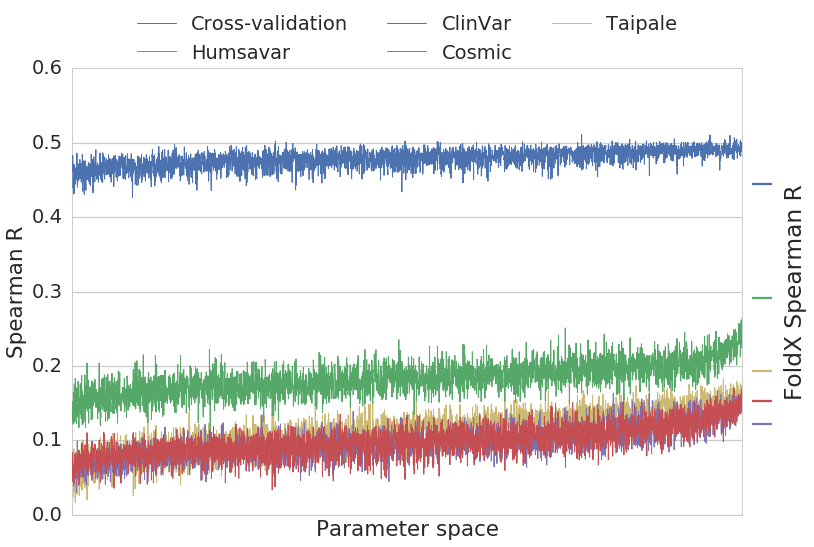

In [34]:
# Plot gridsearch over parameter space
fg, ax = plt.subplots(figsize=(12, 8))

ax = (
    df[columns]
    .rename(columns={
        CORRELATION_TYPE: 'Cross-validation', 
        '{}_{}_ddg_exp_vs_ddg{}'.format(CORRELATION_TYPE, taipale_dataset_name, SUFFIX): 'Taipale',
        '{}_humsavar_del_class_exp_vs_ddg_abs{}'.format(CORRELATION_TYPE, SUFFIX): 'Humsavar',
        '{}_clinvar_del_class_exp_vs_ddg_abs{}'.format(CORRELATION_TYPE, SUFFIX): 'ClinVar',
        '{}_cosmic_del_class_exp_vs_ddg_abs{}'.format(CORRELATION_TYPE, SUFFIX): 'Cosmic',
        })
    .plot(xticks=[], ax=ax, linewidth=1)
)

for i, l in enumerate(ax.get_lines()):
    l.set_zorder(len(columns) - i)

# display(ax.get_children())
# for i, (a, b) in enumerate(zip(
#         ax.get_children()[:len(columns) // 2], 
#         reversed(ax.get_children()[len(columns):len(columns) // 2:-1]))):
#     inc = len(columns) // 2 - i
#     a_zorder = int(a.get_zorder())
#     b_zorder = int(b.get_zorder())
#     print(a_zorder, b_zorder)
#     a.set_zorder(b_zorder)
#     b.set_zorder(a_zorder)

ax.set_xlabel('Parameter space')
ax.set_ylabel('{} R'.format(CORRELATION_TYPE[:-1].capitalize()))
ax.set_ylim(0, 0.6)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3)

text_xpos = ax.get_xlim()[1] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.08
text_ypos = (ax.get_ylim()[1] - ax.get_ylim()[0]) / 2
ax.text(
    text_xpos, text_ypos, 'FoldX Spearman R', rotation=90, 
    horizontalalignment='center', verticalalignment='center')

l = plt.hlines(
    [foldx_corrs[c] for c in columns], 
    xmin=ax.get_xlim()[1] + 50, 
    xmax=ax.get_xlim()[1] + 150, 
    colors=sns.color_palette()[:len(columns)], 
    linestyles='-')

l.set_clip_on(False)

plt.savefig(op.join(NOTEBOOK_NAME, 'gridsearch.png'), bbox_inches='tight', dpi=220)
plt.savefig(op.join(NOTEBOOK_NAME, 'gridsearch.pdf'), bbox_inches='tight')

In [35]:
df_bak = df.copy()

# Feature elimination

## Prepare

Get the best parameters from gridsearch:

In [37]:
clf_opts_best = df.iloc[-1]['clf_opts']
pprint(clf_opts_best)

{'alpha': 0.8,
 'learning_rate': 0.01,
 'loss': 'huber',
 'max_depth': 4,
 'max_features': 0.1,
 'min_samples_leaf': 17,
 'n_estimators': 2000}


In [38]:
1.896409 / 6.5

0.29175523076923077

## Run feature elimination

In [39]:
FE_SUFFIX = '_2'

In [40]:
# Configure feature elimination
FEATURE_COLUMNS = elaspic.elaspic_predictor.FEATURE_COLUMNS_CORE[:]
FEATURE_COLUMNS.remove('dg_change')

params = {
    **clf_opts_best,
    'data_set': protherm_dataset_name,
    'data_file': op.abspath(op.join(NOTEBOOK_NAME, 'TRAINING_SETS_NONULL.pkl')),
}


def run_feature_elimination(features):
    # Parameters
    _parameter_grid = {
        **{k: [v] for k, v in params.items()},
        'max_features': [
            min(1.0, params['max_features'] * len(FEATURE_COLUMNS) / len(features))
        ],
        'features': [
            ':'.join(f for i, f in enumerate(features) if i != skip_i) for skip_i in range(len(features))
        ]
    }
    _system_commands = [
        (i, get_system_command(**params)) 
        for i, params 
        in enumerate(jobsubmitter.iterate_parameters(**_parameter_grid))
    ]

    _js = jobsubmitter.JobSubmitter(
        'feature_elimination{}{}_features{}'.format(SUFFIX, FE_SUFFIX, len(features)),
        'sge://:@192.168.6.201', op.abspath(NOTEBOOK_NAME),
        email='ostrokach@gmail.com', force_new_folder=False,
        nproc=1, queue='medium', walltime='06:00:00', mem='6G',
        concurrent_job_limit=800
    )
    print(_js.job_name)
    
    with _js.connect():
        _js.submit(_system_commands)
   
    # Get job status
    df = _js.job_status(_system_commands)
    time.sleep(10)
    print(Counter(df['status']))
    while not (df['status'] == 'done').all():
        time.sleep(60)
        df = _js.job_status(_system_commands)
        print(Counter(df['status']))

    df['correlation_avg'] = (
        df['spearmanr'] * 2 + 
        df['spearmanr_{}_ddg_exp_vs_ddg'.format(taipale_dataset_name)] * 2 + 
        df['spearmanr_humsavar_del_class_exp_vs_ddg_abs'] + 
        df['spearmanr_clinvar_del_class_exp_vs_ddg_abs'] + 
        df['spearmanr_cosmic_del_class_exp_vs_ddg_abs']
    ) / 7

    df = df.sort_values('correlation_avg', ascending=True)
    
    print("Correlation AVG: {:5}".format(df.iloc[-1]['correlation_avg']))
    features_best = df.iloc[-1]['features'].split(':')
    
    run_feature_elimination(features_best)

In [41]:
# Configure feature elimination part-way
features = FEATURE_COLUMNS
n_features = 17

_parameter_grid = {
    **{k: [v] for k, v in params.items()},
    'max_features': [
        min(1.0, params['max_features'] * len(FEATURE_COLUMNS) / len(features))
    ],
    'features': [
        ':'.join(f for i, f in enumerate(features) if i != skip_i) for skip_i in range(len(features))
    ][:n_features]
}
_system_commands = [
    (i, get_system_command(**params)) 
    for i, params 
    in enumerate(jobsubmitter.iterate_parameters(**_parameter_grid))
]

# Run gridsearch on cluster
log_base_dir = op.abspath(op.join(NOTEBOOK_NAME, '_reg_gridsearch'))

_js = jobsubmitter.JobSubmitter(
    'xv_fe_{}_features{}'.format(n_features, '_diffseqi' if DIFFSEQI else ''),
    'pbs://:@192.168.233.150', log_base_dir,
    email='ostrokach@gmail.com', force_new_folder=False,
    nproc=1, queue='medium', walltime='06:00:00', mem='6G',
    concurrent_job_limit=800
)
print(_js.job_name)

# Get job status
df = _js.job_status(_system_commands)
time.sleep(10)
print(Counter(df['status']))

df['correlation_avg'] = (
    df['spearmanr'] * 2 + 
    df['spearmanr_taipale_ddg_exp_vs_ddg{}'.format(SUFFIX)] * 2 + 
    df['spearmanr_humsavar_del_class_exp_vs_ddg_abs{}'.format(SUFFIX)] + 
    df['spearmanr_clinvar_del_class_exp_vs_ddg_abs{}'.format(SUFFIX)] + 
    df['spearmanr_cosmic_del_class_exp_vs_ddg_abs{}'.format(SUFFIX)]
) / 7

df = df.sort_values('correlation_avg', ascending=True)
print("Correlation AVG: {:5}".format(df.iloc[-1]['correlation_avg']))

features_best = df.iloc[-1]['features'].split(':')
assert len(features_best) == (n_features - 1)
print(features_best)

Using an existing folder for log output. This is dangerous!!!


xv_fe_17_features_diffseqi
Counter({'done': 17})
Correlation AVG: 0.28762553133214375
['entropy_sidechain_wt', 'backbone_hbond_change', 'sidechain_hbond_change', 'electrostatics_change', 'solvation_polar_change', 'solvation_hydrophobic_change', 'van_der_waals_clashes_change', 'torsional_clash_change', 'backbone_clash_change', 'helix_dipole_change', 'disulfide_change', 'energy_ionisation_change', 'pcv_vdw_self_wt', 'pcv_vdw_self_change', 'provean_score', 'secondary_structure_wt']


## Results

In [42]:
# Read results
best_dfs = []
best_features = []

try:
    del i
except NameError:
    pass


for n_features in range(len(FEATURE_COLUMNS), 1, -1):
    # Parameters
    _parameter_grid = {
        **{k: [v] for k, v in params.items()},
        'features': list(range(n_features)),
    }
    _system_commands = [
        (n_features, get_system_command(**params)) 
        for n_features, params 
        in enumerate(jobsubmitter.iterate_parameters(**_parameter_grid))
    ]

    _js = jobsubmitter.JobSubmitter(
        'feature_elimination{}{}_features{}'.format(SUFFIX, FE_SUFFIX, n_features),
        'sge://:@192.168.6.201', op.abspath(NOTEBOOK_NAME),
        email='ostrokach@gmail.com', force_new_folder=False,
        nproc=1, queue='medium', walltime='06:00:00', mem='6G',
        concurrent_job_limit=800
    )
    print(_js.job_name)
    
    # Get job status
    df = _js.job_status(_system_commands)
    df['n_features'] = df['features'].str.count(':') + 1
    _before = df.shape[0]
    df = df[df['n_features'] == (n_features - 1)]
    _after = df.shape[0]
    _n_lost = (_before - _after)
    if _n_lost:
        print(_js.job_name, end=' ')
        print("Wrong number of features for {} rows!".format(_before - _after))
        sys.stdout.flush()

        
    df['correlation_avg'] = (
        df['spearmanr'] * 2 + 
        df['spearmanr_{}_ddg_exp_vs_ddg{}'.format(taipale_dataset_name, SUFFIX)] * 2 + 
        df['spearmanr_humsavar_del_class_exp_vs_ddg_abs{}'.format(SUFFIX)] + 
        df['spearmanr_clinvar_del_class_exp_vs_ddg_abs{}'.format(SUFFIX)] + 
        df['spearmanr_cosmic_del_class_exp_vs_ddg_abs{}'.format(SUFFIX)]
    ) / 7
    df = df.sort_values('correlation_avg', ascending=True)
    best_dfs.append(df.iloc[-1:None])
    
    features = df.iloc[-1]['features'].split(':')
    best_features.append((n_features, len(features), features,))

best_df = pd.concat(best_dfs, ignore_index=True)

Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features70


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features69


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features68


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features67


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features66


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features65


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features64


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features63


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features62


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features61


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features60


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features59


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features58


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features57


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features56


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features55


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features54


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features53


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features52


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features51


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features50


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features49


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features48


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features47


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features46


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features45


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features44


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features43


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features42


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features41


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features40


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features39


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features38


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features37


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features36


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features35


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features34


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features33


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features32


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features31


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features30


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features29


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features28


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features27


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features26


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features25


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features24


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features23


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features22


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features21


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features20


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features19


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features18


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features17


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features16


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features15


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features14


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features13


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features12


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features11


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features10


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features9


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features8


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features7


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features6


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features5


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features4


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features3


Using an existing folder for log output. This is dangerous!!!


feature_elimination_2_features2


## Statistics

In [44]:
feature_elimination_wtest_df = best_df.copy()

In [45]:
# (dataset_name, dataset_label)
def get_test_columns(suffix_test):
    return [
        ('correlation_avg', 'Combined'),
        ('spearmanr', 'Cross-validation'),
        ('spearmanr_{}{}_ddg_exp_vs_ddg{}'.format(taipale_dataset_name, suffix_test, SUFFIX), 'Taipale'),
        ('spearmanr_humsavar{}_del_class_exp_vs_ddg_abs{}'.format(suffix_test, SUFFIX), 'Humsavar'),
        ('spearmanr_clinvar{}_del_class_exp_vs_ddg_abs{}'.format(suffix_test, SUFFIX), 'ClinVar'),
        ('spearmanr_cosmic{}_del_class_exp_vs_ddg_abs{}'.format(suffix_test, SUFFIX), 'COSMIC'),
    ]

Feature elimination on the train dataset


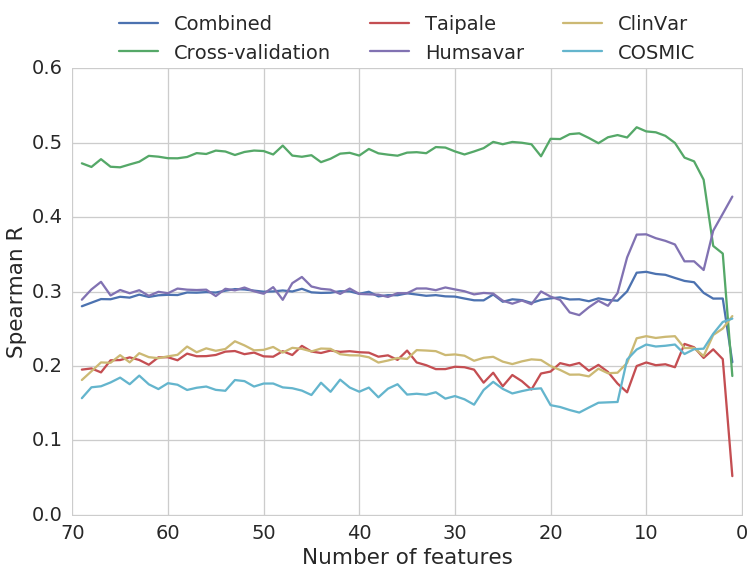

In [46]:
# Train curve for feature elimination
print('Feature elimination on the train dataset')

fg, ax = plt.subplots(figsize=(12, 8))

for test_column, test_label in get_test_columns(suffix_test=''):
    plt.plot(
        feature_elimination_wtest_df['n_features'], 
        feature_elimination_wtest_df[test_column], label=test_label)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3)
plt.xlabel('Number of features')
plt.ylabel('Spearman R')
plt.gca().invert_xaxis()

Feature elimination on the validation dataset


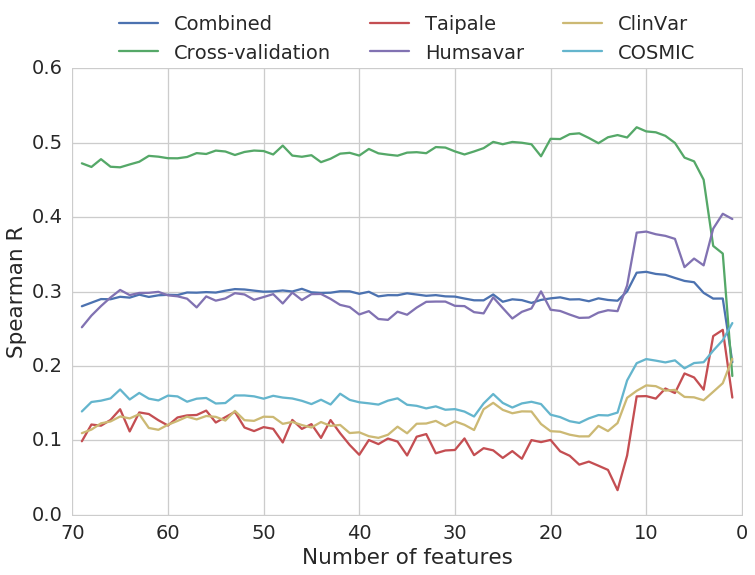

In [47]:
# Validation curve for feature elimination
print("Feature elimination on the validation dataset")

fg, ax = plt.subplots(figsize=(12, 8))

for test_column, test_label in get_test_columns(suffix_test='_test'):
    plt.plot(
        feature_elimination_wtest_df['n_features'], 
        feature_elimination_wtest_df[test_column], label=test_label)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3)
plt.xlabel('Number of features')
plt.ylabel('Spearman R')
plt.gca().invert_xaxis()

n_features_best 10


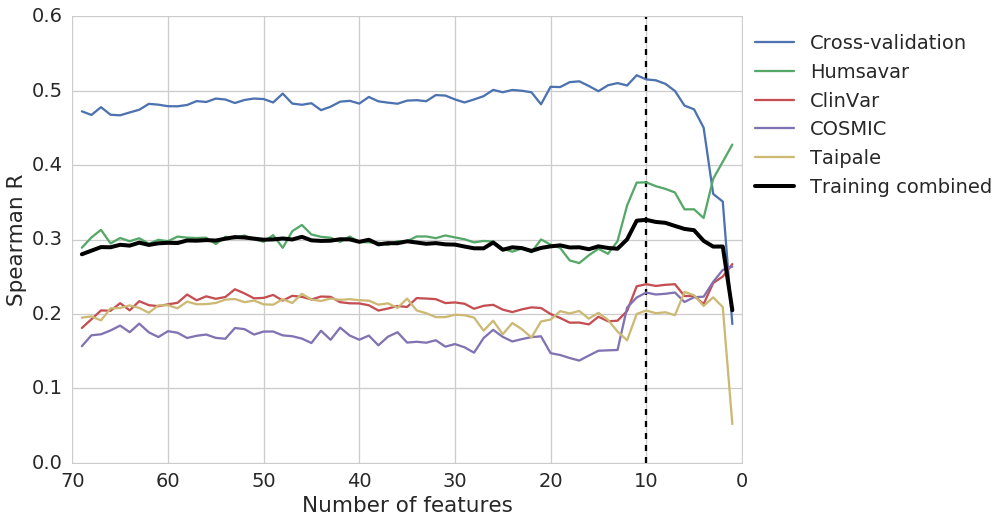

In [48]:
# Train + validation curve for feature elimination
DO_TEST = False
test_suffixes = ['', '_test'] if DO_TEST else ['']

df = feature_elimination_wtest_df
fg, ax = plt.subplots(figsize=(12, 8))

plt.plot(feature_elimination_wtest_df['n_features'], 
         feature_elimination_wtest_df['spearmanr'], 
         label='Cross-validation', 
         color=sns.palettes.color_palette()[0], 
         linestyle='-')

for test_suffix in test_suffixes:
    plt.plot(feature_elimination_wtest_df['n_features'], 
             feature_elimination_wtest_df['spearmanr_humsavar{}_del_class_exp_vs_ddg_abs'.format(test_suffix)], 
             label='Humsavar' + test_suffix.replace('_', ' ').upper(), 
             color=sns.palettes.color_palette()[1], 
             linestyle='--' if test_suffix else '-')

for test_suffix in test_suffixes:
    plt.plot(df['n_features'], 
             feature_elimination_wtest_df['spearmanr_clinvar{}_del_class_exp_vs_ddg_abs'.format(test_suffix)], 
             label='ClinVar' + test_suffix.replace('_', ' ').upper(),
             color=sns.palettes.color_palette()[2], 
             linestyle='--' if test_suffix else '-')

for test_suffix in test_suffixes:
    plt.plot(feature_elimination_wtest_df['n_features'], 
             feature_elimination_wtest_df['spearmanr_cosmic{}_del_class_exp_vs_ddg_abs'.format(test_suffix)], 
             label='COSMIC' + test_suffix.replace('_', ' ').upper(),
             color=sns.palettes.color_palette()[3],
             linestyle='--' if test_suffix else '-')
    
    
plt.plot(feature_elimination_wtest_df['n_features'], 
     feature_elimination_wtest_df['spearmanr_taipale_diffseqi_ddg_exp_vs_ddg'], 
     label='Taipale', 
     color=sns.palettes.color_palette()[4],
     linestyle='-')


plt.plot(feature_elimination_wtest_df['n_features'], 
         feature_elimination_wtest_df['correlation_avg'], 
         label='Training combined', 
         color='k', 
         linestyle='-',
         linewidth=4)


# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=5)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1), ncol=1)
plt.xlabel('Number of features')
plt.ylabel('Spearman R')
plt.gca().invert_xaxis()


n_features_best = df[df['correlation_avg'] == df['correlation_avg'].max()]['n_features'].values[0]
print('n_features_best', n_features_best)
plt.vlines(n_features_best, 0, 0.6, linestyle='--')

plt.savefig(op.join(NOTEBOOK_NAME, 'feature_elimination.png'), bbox_inches='tight', dpi=220)
plt.savefig(op.join(NOTEBOOK_NAME, 'feature_elimination.pdf'), bbox_inches='tight')

In [49]:
# Extract best values
df_best = df[df['correlation_avg'] == df['correlation_avg'].max()]
display(HTML('<b>df_best'), df_best)

n_features_best = int(df_best['n_features'])
display(HTML('<b>n_features_best'), n_features_best)

features_best = sorted(df_best['features'].str.split(':').values[0])
display(HTML('<b>features_best'), features_best)

clf_options_best = df_best['clf_opts'].values[0]
display(HTML('<b>clf_options_best'), clf_options_best)

,clf_opts,features,job_id,pearsonr,pearsonr_clinvar_del_class_exp_vs_ddg_abs,pearsonr_clinvar_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_del_class_exp_vs_ddg_abs_lt40,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_clinvar_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_class_exp_vs_ddg_abs,pearsonr_cosmic_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_del_score_exp_vs_ddg_abs,pearsonr_cosmic_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_del_score_exp_vs_ddg_abs_lt40,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_cosmic_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_40to80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_gt80,pearsonr_cosmic_test_del_score_exp_vs_ddg_abs_lt40,pearsonr_humsavar_del_class_exp_vs_ddg_abs,pearsonr_humsavar_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_del_class_exp_vs_ddg_abs_lt40,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_40to80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_gt80,pearsonr_humsavar_test_del_class_exp_vs_ddg_abs_lt40,pearsonr_taipale_ddg_exp_vs_ddg,pearsonr_taipale_ddg_exp_vs_ddg_40to80,pearsonr_taipale_ddg_exp_vs_ddg_gt80,pearsonr_taipale_ddg_exp_vs_ddg_lt40,pearsonr_taipale_diffseqi_ddg_exp_vs_ddg,pearsonr_taipale_diffseqi_ddg_exp_vs_ddg_40to80,pearsonr_taipale_diffseqi_ddg_exp_vs_ddg_gt80,pearsonr_taipale_diffseqi_ddg_exp_vs_ddg_lt40,pearsonr_taipale_diffseqi_test_ddg_exp_vs_ddg,pearsonr_taipale_diffseqi_test_ddg_exp_vs_ddg_40to80,pearsonr_taipale_diffseqi_test_ddg_exp_vs_ddg_gt80,pearsonr_taipale_diffseqi_test_ddg_exp_vs_ddg_lt40,pearsonr_taipale_test_ddg_exp_vs_ddg,pearsonr_taipale_test_ddg_exp_vs_ddg_40to80,pearsonr_taipale_test_ddg_exp_vs_ddg_gt80,pearsonr_taipale_test_ddg_exp_vs_ddg_lt40,r2,r2_clinvar_del_class_exp_vs_ddg_abs,r2_clinvar_del_class_exp_vs_ddg_abs_40to80,r2_clinvar_del_class_exp_vs_ddg_abs_gt80,r2_clinvar_del_class_exp_vs_ddg_abs_lt40,r2_clinvar_test_del_class_exp_vs_ddg_abs,r2_clinvar_test_del_class_exp_vs_ddg_abs_40to80,r2_clinvar_test_del_class_exp_vs_ddg_abs_gt80,r2_clinvar_test_del_class_exp_vs_ddg_abs_lt40,r2_cosmic_del_class_exp_vs_ddg_abs,r2_cosmic_del_class_exp_vs_ddg_abs_40to80,r2_cosmic_del_class_exp_vs_ddg_abs_gt80,r2_cosmic_del_class_exp_vs_ddg_abs_lt40,r2_cosmic_del_score_exp_vs_ddg_abs,r2_cosmic_del_score_exp_vs_ddg_abs_40to80,r2_cosmic_del_score_exp_vs_ddg_abs_gt80,r2_cosmic_del_score_exp_vs_ddg_abs_lt40,r2_cosmic_test_del_class_exp_vs_ddg_abs,r2_cosmic_test_del_class_exp_vs_ddg_abs_40to80,r2_cosmic_test_del_class_exp_vs_ddg_abs_gt80,r2_cosmic_test_del_class_exp_vs_ddg_abs_lt40,r2_cosmic_test_del_score_exp_vs_ddg_abs,r2_cosmic_test_del_score_exp_vs_ddg_abs_40to80,r2_cosmic_test_del_score_exp_vs_ddg_abs_gt80,r2_cosmic_test_del_score_exp_vs_ddg_abs_lt40,r2_humsavar_del_class_exp_vs_ddg_abs,r2_humsavar_del_class_exp_vs_ddg_abs_40to80,r2_humsavar_del_class_exp_vs_ddg_abs_gt80,r2_humsavar_del_class_exp_vs_ddg_abs_lt40,r2_humsavar_test_del_class_exp_vs_ddg_abs,r2_humsavar_test_del_class_exp_vs_ddg_abs_40to80,r2_humsavar_test_del_class_exp_vs_ddg_abs_gt80,r2_humsavar_test_del_class_exp_vs_ddg_abs_lt40,r2_taipale_ddg_exp_vs_ddg,r2_taipale_ddg_exp_vs_ddg_40to80,r2_taipale_ddg_exp_vs_ddg_gt80,r2_taipale_ddg_exp_vs_ddg_lt40,r2_taipale_diffseqi_ddg_exp_vs_ddg,r2_taipale_diffseqi_ddg_exp_vs_ddg_40to80,r2_taipale_diffseqi_ddg_exp_vs_ddg_gt80,r2_taipale_diffseqi_ddg_exp_vs_ddg_lt40,r2_taipale_diffseqi_test_ddg_exp_vs_ddg,r2_taipale_diffseqi_test_ddg_exp_vs_ddg_

10

['backbone_hbond_change',
 'electrostatics_change',
 'energy_ionisation_change',
 'pcv_salt_opposite_change',
 'pcv_vdw_self_change',
 'provean_score',
 'secondary_structure_wt',
 'solvation_polar_change',
 'solvent_accessibility_wt',
 'van_der_waals_change']

{'alpha': 0.8,
 'learning_rate': 0.01,
 'loss': 'huber',
 'max_depth': 4,
 'max_features': 0.6363636363636364,
 'min_samples_leaf': 17,
 'n_estimators': 2000}

In [50]:
sorted(features_best)

['backbone_hbond_change',
 'electrostatics_change',
 'energy_ionisation_change',
 'pcv_salt_opposite_change',
 'pcv_vdw_self_change',
 'provean_score',
 'secondary_structure_wt',
 'solvation_polar_change',
 'solvent_accessibility_wt',
 'van_der_waals_change']

In [51]:
features_best_meta = {
    'backbone_clash_change': 'FoldX backbone clash (mut - wt)',
    'backbone_hbond_change': 'FoldX backbone hydrogen bond (mut - wt)',
    'disulfide_change': 'FoldX disulfide (mut - wt)',
    'electrostatics_change': 'FoldX electrostatics (mut - wt)' ,
    'energy_ionisation_change': 'FoldX ionization energy (mut - wt)',
    'pcv_vdw_self_change': 'ELASPIC PhysicoChemical: number of carbons on the wt chain (mut - wt)',
    'pcv_vdw_self_wt': 'ELASPIC PhysicoChemical: number of carbons on the wt chain (wt)',
    'provean_score': 'Provean deleteriousness score',
    'secondary_structure_wt': 'Stride secondary structure (mut - wt)',
    'solvation_polar_change': 'FoldX solvation energy (mut - wt)',
    'torsional_clash_change': 'FoldX torsional clash change (mut - wt)',
    'van_der_waals_clashes_change': 'FoldX Van der Waals clash change (mut - wt)',
}

In [52]:
xx = pd.set_option('display.max_colwidth', 100)
xx = pd.DataFrame(list(features_best_meta.items()), columns=['feature_name', 'feature_description'])
xx = xx.sort_values('feature_name')
xx

,feature_name,feature_description
4,backbone_clash_change,FoldX backbone clash (mut - wt)
7,backbone_hbond_change,FoldX backbone hydrogen bond (mut - wt)
5,disulfide_change,FoldX disulfide (mut - wt)
9,electrostatics_change,FoldX electrostatics (mut - wt)
2,energy_ionisation_change,FoldX ionization energy (mut - wt)
6,pcv_vdw_self_change,ELASPIC PhysicoChemical: number of carbons on the wt chain (mut - wt)
0,pcv_vdw_self_wt,ELASPIC PhysicoChemical: number of carbons on the wt chain (wt)
8,provean_score,Provean deleteriousness score
10,secondary_structure_wt,Stride secondary structure (mut - wt)
3,solvation_polar_change,FoldX solvation energy (mut - wt)


# Compare with FoldX

In [53]:
try:
    clf_options_best = clf_options_best
except NameError:
    print("Using cached data...")
    clf_options_best = {
        'alpha': 0.8,
        'learning_rate': 0.01,
        'loss': 'huber',
        'max_depth': 4,
        'max_features': 0.6363636363636364,
        'min_samples_leaf': 17,
        'n_estimators': 2000
     }

In [54]:
try:
    features_best = features_best
except NameError:
    print("Using cached data...")
    features_best = [
        'backbone_hbond_change',
        'electrostatics_change',
        'energy_ionisation_change',
        'pcv_salt_opposite_change',
        'pcv_vdw_self_change',
        'provean_score',
        'secondary_structure_wt',
        'solvation_polar_change',
        'solvent_accessibility_wt',
        'van_der_waals_change'
    ]

In [57]:
import sklearn
clf = sklearn.ensemble.GradientBoostingRegressor(**clf_options_best)

In [58]:
clf.fit(
    TRAINING_SETS_NONULL[protherm_dataset_name][features_best],
    TRAINING_SETS_NONULL[protherm_dataset_name]['ddg_exp'])

GradientBoostingRegressor(alpha=0.8, init=None, learning_rate=0.01,
             loss='huber', max_depth=4, max_features=0.6363636363636364,
             max_leaf_nodes=None, min_samples_leaf=17, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=2000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [63]:
with open(op.join(NOTEBOOK_NAME, 'core_clf_features.json'), 'w') as ofh:
    json.dump(features_best, ofh)

In [64]:
with open(op.join(NOTEBOOK_NAME, 'core_clf_options.json'), 'w') as ofh:
    json.dump(clf_options_best, ofh)

In [65]:
with open(op.join(NOTEBOOK_NAME, 'core_clf.pkl'), 'wb') as ofh:
    pickle.dump(clf, ofh, pickle.HIGHEST_PROTOCOL)

In [59]:
for _df in TRAINING_SETS_NONULL.values():
    _df['ddg_pred'] = clf.predict(_df[features_best])

TODO: Use [MacNemar's test](http://stats.stackexchange.com/questions/76875/what-is-the-difference-between-mcnemars-test-and-the-chi-squared-test-and-how) to see if the correlations are statistically significant.

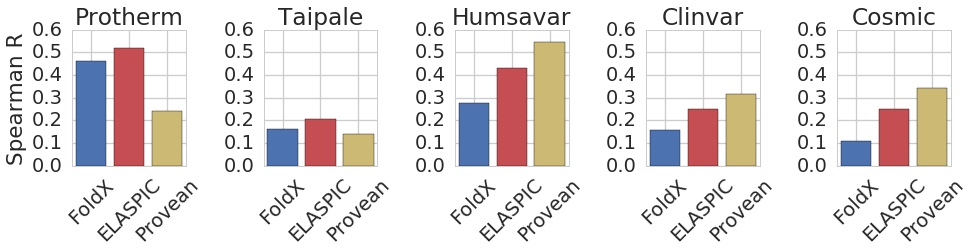

In [62]:
# Compare ELASPIC and FoldX on the test set (NO ABS)
fg, axes = plt.subplots(1, 5, figsize=(14, 4))
axes[0].set_ylabel('Spearman R')
for i, test_dataset in enumerate(['protherm', 'taipale_test', 'humsavar_test', 'clinvar_test', 'cosmic_test']):
    ax = axes[i]
    # print(test_dataset)
    if test_dataset in ['protherm', 'taipale_test']:
        foldx_r = sp.stats.spearmanr(
            TRAINING_SETS_NONULL[test_dataset]['dg_change'], 
            TRAINING_SETS_NONULL[test_dataset]['ddg_exp'])[0]
        if test_dataset == 'protherm':
            elaspic_r = 0.520392
        else:
            elaspic_r = sp.stats.spearmanr(
                TRAINING_SETS_NONULL[test_dataset]['ddg_pred'], 
                TRAINING_SETS_NONULL[test_dataset]['ddg_exp'])[0]
        provean_r = sp.stats.spearmanr(
            TRAINING_SETS_NONULL[test_dataset]['provean_score'], 
            TRAINING_SETS_NONULL[test_dataset]['ddg_exp'])[0] * -1
    else:
        foldx_r = sp.stats.spearmanr(
            TRAINING_SETS_NONULL[test_dataset]['dg_change'],  # NO ABS!!!
            TRAINING_SETS_NONULL[test_dataset]['del_class_exp'])[0]
        elaspic_r = sp.stats.spearmanr(
            TRAINING_SETS_NONULL[test_dataset]['ddg_pred'],  # NO ABS!!!
            TRAINING_SETS_NONULL[test_dataset]['del_class_exp'])[0]
        provean_r = sp.stats.spearmanr(
            TRAINING_SETS_NONULL[test_dataset]['provean_score'], 
            TRAINING_SETS_NONULL[test_dataset]['del_class_exp'])[0] * -1
    ax.bar(
        [1, 2, 3], 
        [foldx_r, elaspic_r, provean_r],
        tick_label=['FoldX', 'ELASPIC', 'Provean'], 
        align='center', 
        color=[sns.palettes.color_palette()[0], 
               sns.palettes.color_palette()[2],
               sns.palettes.color_palette()[4]])
    ax.set_ylim(0, 0.60)
    ax.set_title(test_dataset.split('_')[0].capitalize())
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
    # print(elaspic_r, foldx_r)

plt.tight_layout()

plt.savefig(op.join(NOTEBOOK_NAME, 'final_performance.png'), bbox_inches='tight', dpi=220)
plt.savefig(op.join(NOTEBOOK_NAME, 'final_performance.pdf'), bbox_inches='tight')